<a href="https://colab.research.google.com/github/haidour18/Benchemarking-Recommender-systems-/blob/main/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!pip install -q keras
!pip install numpy
!pip install sklearn
!pip install scipy
!pip install surprise
!pip install apyori
!pip install matrix_factorization
!pip install factor-analyzer
!pip install python-helper

     |████████████████████████████████| 11.8MB 362kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1615289 sha256=cf205e504fd9bea986b5a85704a598ead5e4296e06bbab116d29ca6222dd3e8b
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
  Created wheel for apyori: filename=apyori-1.1.2-cp37-none-any.whl size=5975 sha256=f682b840c5f3fed2ac4c9fb20f62d54058b214fd89dc91defba99d15cec55b8b
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori
     |████████████████████████████████| 22.3MB 55.7MB/s 
  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-cp37-none-any.whl size=16468 sha256=f9d8cbe7b818ec669adc3c6154c7595ad6715e856178ee674c5d225606685058
  Stored in directory: /root/.cache/pip/wheels/db/ef/99/19df32b6eb88678b0e3a42d2e24955e7753b2de44615111b

In [2]:
#All the header files required for the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, glob , csv
import time, joblib
import pandas as pd
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from zipfile import ZipFile as zip
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from IPython.display import display
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics.pairwise import cosine_similarity as cos
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [3]:
from google.colab import files 
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change permissions 
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d rounakbanik/the-movies-dataset


 95% 217M/228M [00:02<00:00, 92.5MB/s]
100% 228M/228M [00:02<00:00, 98.7MB/s]


In [6]:
# Dézippier le .zip obtenu
from zipfile import ZipFile
file_name = 'the-movies-dataset.zip'
with ZipFile (file_name ,'r') as zip : 
  zip.extractall()
  print('Done')

Done


In [11]:

ratings=pd.read_csv("ratings.csv")
ratings.head(4)


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546


In [12]:

print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (26024289, 4) 

Max values in dataset are 
 userId       2.708960e+05
movieId      1.762750e+05
rating       5.000000e+00
timestamp    1.501830e+09
dtype: float64 

Min values in dataset are 
 userId               1.0
movieId              1.0
rating               0.5
timestamp    789652004.0
dtype: float64 



In [13]:
# Filtering data for only 4+ ratings
ratings = ratings[ratings['rating'] >= 4.0]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (12981742, 4) 

Max values in dataset are 
 userId       2.708960e+05
movieId      1.762710e+05
rating       5.000000e+00
timestamp    1.501829e+09
dtype: float64 

Min values in dataset are 
 userId               1.0
movieId              1.0
rating               4.0
timestamp    789652004.0
dtype: float64 



In [14]:
movies_list = np.unique(ratings['movieId'])[:200]
ratings = ratings.loc[ratings['movieId'].isin(movies_list)]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (776269, 4) 

Max values in dataset are 
 userId       2.708960e+05
movieId      2.010000e+02
rating       5.000000e+00
timestamp    1.501823e+09
dtype: float64 

Min values in dataset are 
 userId               1.0
movieId              1.0
rating               4.0
timestamp    789652009.0
dtype: float64 



In [15]:
users_fav_movies = ratings.loc[:, ['userId', 'movieId']]


In [16]:
users_fav_movies = ratings.reset_index(drop = True)


In [17]:
users_fav_movies.T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,776229,776230,776231,776232,776233,776234,776235,776236,776237,776238,776239,776240,776241,776242,776243,776244,776245,776246,776247,776248,776249,776250,776251,776252,776253,776254,776255,776256,776257,776258,776259,776260,776261,776262,776263,776264,776265,776266,776267,776268
userId,1.000000e+00,2.0,2.0,8.000000e+00,8.000000e+00,9.000000e+00,9.000000e+00,10.0,10.0,1.100000e+01,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,1.500000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01,18.0,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.200000e+01,2.200000e+01,24.0,24.0,...,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,2.708870e+05,270891.0,270891.0,270891.0,270891.0,270891.0,270891.0,270891.0,2.708920e+05,2.708920e+05,2.708920e+05,270893.0,270893.0,270893.0,270893.0,270893.0,270893.0,270893.0,2.708940e+05,270895.0,270895.0,270895.0,270895.0,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05,2.708960e+05
movieId,1.470000e+02,64.0,79.0,1.000000e+00,4.700000e+01,1.000000e+00,1.500000e+02,150.0,165.0,3.400000e+01,1.0,16.0,17.0,29.0,34.0,47.0,50.0,82.0,97.0,123.0,125.0,150.0,162.0,175.0,176.0,194.0,6.000000e+00,3.200000e+01,5.000000e+01,1.110000e+02,1.980000e+02,81.0,1.000000e+00,3.900000e+01,1.500000e+02,1.610000e+02,1.100000e+02,1.630000e+02,1.0,6.0,...,1.500000e+02,1.600000e+02,1.610000e+02,1.650000e+02,1.850000e+02,1.900000e+02,1.930000e+02,1.960000e+02,2.000000e+02,7.0,11.0,62.0,110.0,140.0,150.0,161.0,1.000000e+00,3.200000e+01,5.000000e+01,1.0,34.0,47.0,50.0,70.0,110.0,165.0,4.700000e+01,34.0,110.0,150.0,161.0,1.000000e+00,1.700000e+01,2.500000e+01,3.200000e+01,3.600000e+01,4.700000e+01,5.000000e+01,1.100000e+02,1.110000e+02
rating,4.500000e+00,4.0,4.0,4.000000e+00,4.000000e+00,4.500000e+00,4.000000e+00,4.0,4.0,4.000000e+00,4.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,4.000000e+00,4.500000e+00,5.000000e+00,5.000000e+00,4.500000e+00,5.0,4.000000e+00,5.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,4.000000e+00,4.0,4.0,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.000000e+00,4.000000e+00,4.000000e+00,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.000000e+00,4.0,4.0,5.0,4.0,4.500000e+00,4.000000e+00,4.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,1.425942e+09,867039612.0,867039325.0,1.013444e+09,1.013444e+09,1.073837e+09,1.073837e+09,846287850.0,846288047.0,1.231677e+09,943912205.0,943913329.0,943911191.0,943913115.0,943913044.0,943912317.0,943911078.0,943911115.0,943911285.0,943912719.0,943912278.0,943913006.0,943911613.0,943911842.0,943912719.0,943912278.0,1.346008e+09,1.485646e+09,1.485651e+09,1.485646e+09,1.485647e+09,965665345.0,1.368361e+09,1.492184e+09,1.432292e+09,1.419976e+09,1.111937e+09,1.111937e+09,979869938.0,979870499.0,...,1.463274e+09,1.463494e+09,1.463494e+09,1.463003e+09,1.463274e+09,1.463535e+09,1.479322e+09,1.463778e+09,1.463580e+09,835259142.0,834405964.0,834405854.0,834405826.0,834405982.0,834405580.0,834405897.0,1.226040e+09,1.226040e+09,1.226040e+09,992896512.0,992896475.0,992332943.0,992332590.0,992417683.0,992417240.0,992332772.0,1.419821e+09,845432277.0,845432120.0,845431989.0,845432120.0,1.257031e+09,1.257034e+09,1.257034e+09,1.257032e+09,1.257034e+09,1.257032e+09,1.257032e+09,1.257031e+09,1.257034e+09


In [21]:
users_fav_movies.to_csv('/content/cleandata.csv')


In [22]:
def moviesListForUsers(users, users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies
    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['userId'] == user]['movieId'])).split('[')[1].split(']')[0])
    return users_movies_list

In [23]:
users = np.unique(users_fav_movies['userId'])
print(users.shape)

(162976,)


In [24]:
users_movies_list = moviesListForUsers(users, users_fav_movies)
print('Movies list for', len(users_movies_list), ' users')
print('A list of first 10 users favourite movies: \n', users_movies_list[:10])

Movies list for 162976  users
A list of first 10 users favourite movies: 
 ['147', '64, 79', '1, 47', '1, 150', '150, 165', '34', '1, 16, 17, 29, 34, 47, 50, 82, 97, 123, 125, 150, 162, 175, 176, 194', '6', '32, 50, 111, 198', '81']


In [27]:
def prepSparseMatrix(list_of_str):
    # list_of_str = A list, which contain strings of users favourite movies separate by comma ",".
    # It will return us sparse matrix and feature names on which sparse matrix is defined 
    # i.e. name of movies in the same order as the column of sparse matrix
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names()

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

sparseMatrix, feature_names = prepSparseMatrix(users_movies_list)


In [30]:
df_sparseMatrix = pd.DataFrame(sparseMatrix, index = users, columns = feature_names)
df_sparseMatrix

,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,129,13,130,131,132,133,134,...,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,92,93,94,95,96,97,98,99
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270892,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
270893,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
270894,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
270895,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
first_6_users_SM = users_fav_movies[users_fav_movies['userId'].isin(users[:6])].sort_values('userId')
first_6_users_SM.T

,0,1,2,3,4,5,6,7,8,9
userId,1.000000e+00,2.0,2.0,8.000000e+00,8.000000e+00,9.000000e+00,9.000000e+00,10.0,10.0,1.100000e+01
movieId,1.470000e+02,64.0,79.0,1.000000e+00,4.700000e+01,1.000000e+00,1.500000e+02,150.0,165.0,3.400000e+01
rating,4.500000e+00,4.0,4.0,4.000000e+00,4.000000e+00,4.500000e+00,4.000000e+00,4.0,4.0,4.000000e+00
timestamp,1.425942e+09,867039612.0,867039325.0,1.013444e+09,1.013444e+09,1.073837e+09,1.073837e+09,846287850.0,846288047.0,1.231677e+09


In [34]:
df_sparseMatrix.loc[np.unique(first_6_users_SM['userId']), list(map(str, np.unique(first_6_users_SM['movieId'])))]


,1,34,47,64,79,147,150,165
1,0,0,0,0,0,1,0,0
2,0,0,0,1,1,0,0,0
8,1,0,1,0,0,0,0,0
9,1,0,0,0,0,0,1,0
10,0,0,0,0,0,0,1,1
11,0,1,0,0,0,0,0,0


Clustering Model

```
## **# This is formatted as code**

> Indented block


```




In [42]:
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

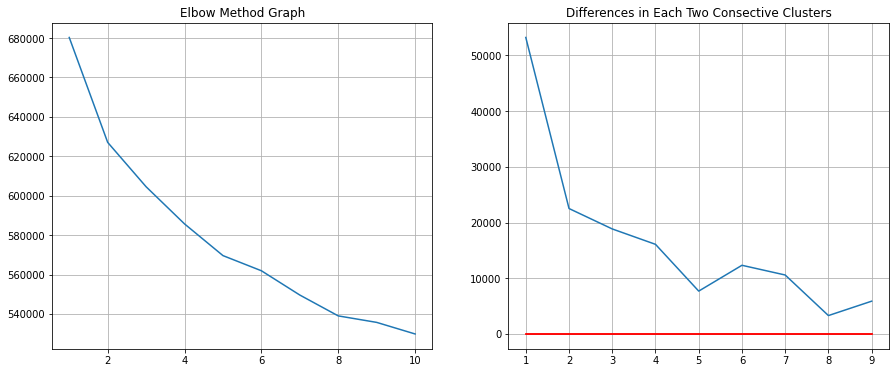

In [49]:
elbow_method = elbowMethod(sparseMatrix)
elbow_method.run(1, 10)
elbow_method.showPlot(boundary = 10)



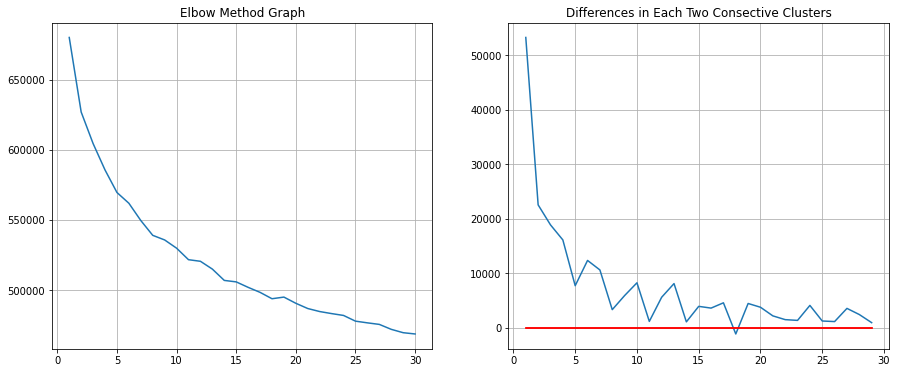

In [50]:
elbow_method.run(11, 30)
elbow_method.showPlot(boundary = 10)



In [51]:
kmeans = KMeans(n_clusters=18, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)

In [52]:
users_cluster = pd.DataFrame(np.concatenate((users.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,162936,162937,162938,162939,162940,162941,162942,162943,162944,162945,162946,162947,162948,162949,162950,162951,162952,162953,162954,162955,162956,162957,162958,162959,162960,162961,162962,162963,162964,162965,162966,162967,162968,162969,162970,162971,162972,162973,162974,162975
userId,1,2,8,9,10,11,12,15,16,18,20,22,24,25,27,28,29,30,33,34,35,36,37,40,41,43,44,46,47,49,51,52,53,54,55,56,58,59,60,62,...,270833,270834,270835,270836,270837,270840,270843,270844,270846,270847,270849,270850,270851,270852,270854,270857,270858,270859,270860,270861,270863,270867,270868,270869,270871,270872,270875,270876,270877,270879,270882,270883,270885,270887,270891,270892,270893,270894,270895,270896
Cluster,0,0,2,2,16,0,10,0,1,0,16,5,10,0,17,17,3,6,12,9,0,0,16,2,0,0,11,16,10,4,11,1,17,0,11,8,4,17,0,17,...,5,0,0,3,0,5,0,17,16,3,14,13,9,17,0,1,11,0,6,3,2,5,3,8,2,17,2,0,13,0,5,11,6,13,7,8,8,0,14,6


In [55]:
def clustersMovies(users_cluster, users_data):
    clusters = list(users_cluster['Cluster'])
    each_cluster_movies = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(users_cluster[users_cluster['Cluster'] == i]['userId'])
        users_movies_list = list()
        for user in users_list:    
            users_movies_list.extend(list(users_data[users_data['userId'] == user]['movieId']))
        users_movies_counts = list()
        users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['movieId', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_movies


In [56]:
cluster_movies = clustersMovies(users_cluster, users_fav_movies)


In [57]:
cluster_movies[1].T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182
movieId,32,50,47,29,150,6,25,36,111,21,34,165,141,198,58,104,95,70,112,10,39,16,2,62,52,163,162,172,17,194,18,180,185,41,161,11,24,170,101,97,...,102,75,195,8,49,124,126,191,179,77,59,174,138,132,137,136,84,189,53,54,114,108,106,181,167,90,67,169,87,38,148,200,134,56,33,129,115,182,71,201
Count,7970,1926,1196,806,657,588,587,495,392,381,368,367,352,342,315,307,301,282,281,274,260,246,233,222,219,215,199,196,192,183,179,173,163,159,146,146,143,133,131,126,...,7,7,6,6,6,5,5,5,5,4,4,4,4,4,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1


In [58]:
for i in range(15):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users)

Users in Cluster 0 ->  36243
Users in Cluster 1 ->  7970
Users in Cluster 2 ->  15970
Users in Cluster 3 ->  7393
Users in Cluster 4 ->  4433
Users in Cluster 5 ->  11320
Users in Cluster 6 ->  7459
Users in Cluster 7 ->  4076
Users in Cluster 8 ->  6828
Users in Cluster 9 ->  4850
Users in Cluster 10 ->  3998
Users in Cluster 11 ->  7786
Users in Cluster 12 ->  5393
Users in Cluster 13 ->  2008
Users in Cluster 14 ->  7655


In [59]:
def getMoviesOfUser(user_id, users_data):
    return list(users_data[users_data['userId'] == user_id]['movieId'])

In [60]:
def fixClusters(clusters_movies_dataframes, users_cluster_dataframe, users_data, smallest_cluster_size = 11):
    # clusters_movies_dataframes: will be a list which will contain each dataframes of each cluster movies
    # users_cluster_dataframe: will be a dataframe which contain users IDs and their cluster no.
    # smallest_cluster_size: is a smallest cluster size which we want for a cluster to not remove
    each_cluster_movies = clusters_movies_dataframes.copy()
    users_cluster = users_cluster_dataframe.copy()
    # Let convert dataframe in each_cluster_movies to list with containing only movies IDs
    each_cluster_movies_list = [list(df['movieId']) for df in each_cluster_movies]
    # First we will prepair a list which containt lists of users in each cluster -> [[Cluster 0 Users], [Cluster 1 Users], ... ,[Cluster N Users]] 
    usersInClusters = list()
    total_clusters = len(each_cluster_movies)
    for i in range(total_clusters):
        usersInClusters.append(list(users_cluster[users_cluster['Cluster'] == i]['userId']))
    uncategorizedUsers = list()
    i = 0
    # Now we will remove small clusters and put their users into another list named "uncategorizedUsers"
    # Also when we will remove a cluster, then we have also bring back cluster numbers of users which comes after deleting cluster
    # E.g. if we have deleted cluster 4 then their will be users whose clusters will be 5,6,7,..,N. So, we'll bring back those users cluster number to 4,5,6,...,N-1.
    for j in range(total_clusters):
        if len(usersInClusters[i]) < smallest_cluster_size:
            uncategorizedUsers.extend(usersInClusters[i])
            usersInClusters.pop(i)
            each_cluster_movies.pop(i)
            each_cluster_movies_list.pop(i)
            users_cluster.loc[users_cluster['Cluster'] > i, 'Cluster'] -= 1
            i -= 1
        i += 1
    for user in uncategorizedUsers:
        elemProbability = list()
        user_movies = getMoviesOfUser(user, users_data)
        if len(user_movies) == 0:
            print(user)
        user_missed_movies = list()
        for movies_list in each_cluster_movies_list:
            count = 0
            missed_movies = list()
            for movie in user_movies:
                if movie in movies_list:
                    count += 1
                else:
                    missed_movies.append(movie)
            elemProbability.append(count / len(user_movies))
            user_missed_movies.append(missed_movies)
        user_new_cluster = np.array(elemProbability).argmax()
        users_cluster.loc[users_cluster['userId'] == user, 'Cluster'] = user_new_cluster
        if len(user_missed_movies[user_new_cluster]) > 0:
            each_cluster_movies[user_new_cluster] = each_cluster_movies[user_new_cluster].append([{'movieId': new_movie, 'Count': 1} for new_movie in user_missed_movies[user_new_cluster]], ignore_index = True)
    return each_cluster_movies, users_cluster

In [61]:
movies_df_fixed, clusters_fixed = fixClusters(cluster_movies, users_cluster, users_fav_movies, smallest_cluster_size = 6)


In [63]:
j = 0
for i in range(15):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    if len_users < 6:
        print('Users in Cluster ' + str(i) + ' -> ', len_users)
        j += 1
print('Total Cluster which we want to remove -> ', j)

Total Cluster which we want to remove ->  0


In [64]:
print('Length of total clusters before fixing is -> ', len(cluster_movies))
print('Max value in users_cluster dataframe column Cluster is -> ', users_cluster['Cluster'].max())
print('And dataframe is following')
users_cluster.T

Length of total clusters before fixing is ->  18
Max value in users_cluster dataframe column Cluster is ->  17
And dataframe is following


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,162936,162937,162938,162939,162940,162941,162942,162943,162944,162945,162946,162947,162948,162949,162950,162951,162952,162953,162954,162955,162956,162957,162958,162959,162960,162961,162962,162963,162964,162965,162966,162967,162968,162969,162970,162971,162972,162973,162974,162975
userId,1,2,8,9,10,11,12,15,16,18,20,22,24,25,27,28,29,30,33,34,35,36,37,40,41,43,44,46,47,49,51,52,53,54,55,56,58,59,60,62,...,270833,270834,270835,270836,270837,270840,270843,270844,270846,270847,270849,270850,270851,270852,270854,270857,270858,270859,270860,270861,270863,270867,270868,270869,270871,270872,270875,270876,270877,270879,270882,270883,270885,270887,270891,270892,270893,270894,270895,270896
Cluster,0,0,2,2,16,0,10,0,1,0,16,5,10,0,17,17,3,6,12,9,0,0,16,2,0,0,11,16,10,4,11,1,17,0,11,8,4,17,0,17,...,5,0,0,3,0,5,0,17,16,3,14,13,9,17,0,1,11,0,6,3,2,5,3,8,2,17,2,0,13,0,5,11,6,13,7,8,8,0,14,6


In [ ]:
Nmovies=movies.shape[0]

In [ ]:
import ast

# this function extracts words out of dictionaries and formats them
def word_extractor(row_of_words):
    words_joined = []
    if (type(row_of_words)!=str or type(ast.literal_eval(row_of_words))!=list):
        words_joined = ['']
    else:
    # extract words from the dictionaries
        word_list = ast.literal_eval(row_of_words)
        for w in range(0,len(word_list)):
            word_list[w] = word_list[w]['name']
            word_list[w] = word_list[w].replace(" ","")
        words_joined.append(' '.join(word_list))    
    return words_joined

# applying the word_extractor function to dict. features
genres = []
for m in range(0,Nmovies):
    genres.append(word_extractor(movies['genres'][m]))
    movies['genres'][m]=word_extractor(movies['genres'][m])


In [ ]:
movies.head(5)

NameError: ignored

In [ ]:
ratings.rename(columns={'movieId': 'id'},inplace=True)


In [ ]:
ratings.head(5)

,userId,id,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
data=ratings.join(movies,on="id", how='left', lsuffix='_left', rsuffix='_right')
data.tail(35)

,userId,id_left,rating,timestamp,genres,id_right,original_title
26024254,270896,33794,4.0,1257031497,[Action Thriller Crime],90147,奪命金
26024255,270896,34048,3.0,1257034406,[Animation],54509,The Flying Mouse
26024256,270896,35836,3.5,1257033774,[Horror Comedy],340401,Kartoffelsalat - Nicht Fragen!
26024257,270896,40815,4.0,1257032001,[TVMovie Romance],396394,The Convenient Groom
26024258,270896,40819,4.0,1257034287,[TVMovie Drama],343369,Love Finds You in Charm
26024259,270896,41566,3.5,1257034128,[Drama],408203,Tyttö nimeltä Varpu
26024260,270896,44191,5.0,1257031546,[Comedy Action Animation],416445,Revengeance
26024261,270896,44195,4.0,1257034427,[Documentary],187537,William S. Burroughs: Commissioner of Sewers
26024262,270896,45499,3.0,1257034131,NaN,NaN,NaN
26024263,270896,45722,3.5,1257031715,NaN,NaN,NaN


In [ ]:

# Data Processing
# Converting Genres into different columns 
# Here we just create columns and put there initial value as 0
x = data.genres
a = list()
for i in x:
    abc = i
    a.append(abc)
b = a[0]
for i in b:
    data[i] = 0
data.head(15)

,userId,id_left,rating,timestamp,genres,id_right,original_title,Crime Action Comedy Thriller
0,1,110,1.0,1425941529,[Crime Action Comedy Thriller],33542,紅番區,0
1,1,147,4.5,1425942435,[Drama],568,Apollo 13,0
2,1,858,5.0,1425941523,[Fantasy Comedy Family],3587,Bogus,0
3,1,1221,5.0,1425941546,[Western],33,Unforgiven,0
4,1,1246,5.0,1425941556,[Adventure Action],89,Indiana Jones and the Last Crusade,0
5,1,1968,4.0,1425942148,[Adventure],35144,The Journey of Natty Gann,0
6,1,2762,4.5,1425941300,[Horror],28377,Hell Night,0
7,1,2918,5.0,1425941593,[Comedy Drama Family War],37853,Mister Roberts,0
8,1,2959,4.0,1425941601,[Comedy Romance],2690,Irma la Douce,0
9,1,4226,4.0,1425942228,[Crime Thriller],17494,Unlawful Entry,0


In [ ]:
# we assign 1 to all the columns which are present in the Genres
for i in b:
    data.loc[data['genres'].str.contains(i), i] = 1